# 9.2. Convertendo texto bruto em dados de sequência

Ao longo deste livro, frequentemente trabalharemos com dados de texto representados como sequências de palavras, caracteres ou pedaços de palavras. Para começar, precisaremos de algumas ferramentas básicas para converter texto bruto em sequências do formato apropriado. Pipelines de pré-processamento típicos executam as seguintes etapas:

- Carregue texto como strings na memória.

- Divida as strings em tokens (por exemplo, palavras ou caracteres).

- Crie um dicionário de vocabulário para associar cada elemento do vocabulário a um índice numérico.

- Converta o texto em sequências de índices numéricos.

In [5]:
import collections
import random
import re
import torch
from d2l import torch as d2l

# 9.2.1. Lendo o conjunto de dados

Aqui, trabalharemos com The Time Machine , de HG Wells , um livro contendo pouco mais de 30.000 palavras. Embora aplicações reais normalmente envolvam conjuntos de dados significativamente maiores, isso é suficiente para demonstrar o pipeline de pré-processamento. O _download método a seguir lê o texto bruto em uma string.

In [6]:
# https://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt
# https://www.gutenberg.org/ebooks/35

class TimeMachine(d2l.DataModule): #@save
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

data = TimeMachine()
raw_text = data._download()
raw_text[:80]                    # Livro

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Traveller (for so it wi'

Para simplificar, ignoramos pontuação e capitalização ao pré-processar o texto bruto.

In [7]:
@d2l.add_to_class(TimeMachine)  #@save
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

# 9.2.2. Tokenização

Tokens são as unidades atômicas (indivisíveis) de texto. Cada passo de tempo corresponde a 1 token, mas o que constitui precisamente um token é uma escolha de design. Por exemplo, poderíamos representar a frase “Baby needs a new pair of shoes” como uma sequência de 7 palavras, onde o conjunto de todas as palavras compreende um vocabulário grande (tipicamente dezenas ou centenas de milhares de palavras). Ou representaríamos a mesma frase como uma sequência muito maior de 30 caracteres, usando um vocabulário muito menor (há apenas 256 caracteres ASCII distintos). Abaixo, tokenizamos nosso texto pré-processado em uma sequência de caracteres.

In [8]:
@d2l.add_to_class(TimeMachine)  #@save
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

# 9.2.3. Vocabulário

These tokens are still strings. However, the inputs to our models must ultimately consist of numerical inputs. Next, we introduce a class for constructing vocabularies , ie, objects that associate each distinct token value with a unique index. First, we determine the set of unique tokens in our training corpus . We then assign a numerical index to each unique token. Rare vocabulary elements are often dropped for convenience. Whenever we encounter a token at training or test time that had not been previously seen or was dropped from the vocabulary, we represent it by a special "unk" token, signifying that this is an unknown value.

In [9]:
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

Agora construímos um vocabulário para nosso conjunto de dados, convertendo a sequência de strings em uma lista de índices numéricos. Note que não perdemos nenhuma informação e podemos facilmente converter nosso conjunto de dados de volta para sua representação original (string).

In [10]:
vocab = Vocab(tokens)              # objjeto vocab da classe Vocab
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

# ' '(espaço) tem índice 0, 'a' tem índice 1, 'b' tem índice 2, etc.

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


# 9.2.4. Juntando tudo

Usando as classes e métodos acima, empacotamos tudo no seguinte buildmétodo da TimeMachineclasse, que retorna corpus, uma lista de índices de tokens, e vocab, o vocabulário do corpus The Time Machine . As modificações que fizemos aqui são: 
- (i) tokenizamos o texto em caracteres, não palavras, para simplificar o treinamento em seções posteriores; 
- (ii) corpusé uma lista única, não uma lista de listas de tokens, já que cada linha de texto no conjunto de dados The Time Machine não é necessariamente uma frase ou parágrafo.

In [11]:
@d2l.add_to_class(TimeMachine)  #@save
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

# 9.2.5. Estatísticas exploratórias da linguagem

Usando o corpus real e a Vocab classe definida sobre palavras, podemos inspecionar estatísticas básicas sobre o uso de palavras em nosso corpus. Abaixo, construímos um vocabulário a partir de palavras usadas em The Time Machine e imprimimos as dez mais frequentes delas.

In [12]:
words = text.split()    # separação de strings
vocab = Vocab(words)    # faz a indexação
vocab.token_freqs[:10]  # Count token frequencies: 10 most frequents

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

Note que as dez palavras mais frequentes não são tão descritivas. Você pode até imaginar que poderíamos ver uma lista muito semelhante se tivéssemos escolhido qualquer livro aleatoriamente. Artigos como “the” e “a”, pronomes como “i” e “my”, e preposições como “of”, “to” e “in” ocorrem frequentemente porque desempenham papéis sintáticos comuns.

Se você olhar mais abaixo na lista, notará que a frequência das palavras decai rapidamente.

A frequência de palavras tende a seguir uma distribuição de lei de potência (especificamente a Zipfiana) conforme descemos as classificações. Para ter uma ideia melhor, plotamos o número da frequência de palavras.

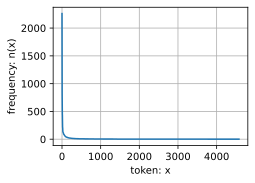

In [13]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)')

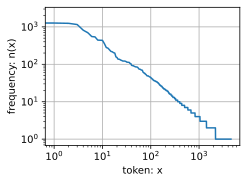

In [14]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

In [15]:
freqs

[2261,
 1267,
 1245,
 1155,
 816,
 695,
 552,
 541,
 443,
 440,
 437,
 354,
 281,
 270,
 243,
 221,
 216,
 204,
 200,
 158,
 152,
 137,
 137,
 134,
 129,
 127,
 123,
 122,
 122,
 122,
 120,
 118,
 114,
 114,
 113,
 113,
 112,
 106,
 105,
 103,
 94,
 93,
 92,
 92,
 91,
 89,
 88,
 87,
 86,
 85,
 85,
 85,
 84,
 84,
 82,
 79,
 77,
 75,
 74,
 74,
 74,
 73,
 72,
 71,
 70,
 70,
 70,
 69,
 66,
 62,
 61,
 60,
 59,
 59,
 57,
 57,
 57,
 55,
 54,
 54,
 53,
 52,
 51,
 50,
 49,
 49,
 49,
 49,
 49,
 49,
 48,
 48,
 47,
 47,
 46,
 46,
 46,
 46,
 45,
 45,
 44,
 43,
 43,
 43,
 42,
 42,
 41,
 40,
 40,
 40,
 40,
 39,
 38,
 38,
 37,
 37,
 37,
 37,
 37,
 36,
 36,
 36,
 36,
 36,
 36,
 35,
 35,
 35,
 35,
 35,
 34,
 34,
 34,
 34,
 34,
 34,
 33,
 33,
 33,
 32,
 32,
 32,
 32,
 32,
 31,
 31,
 31,
 30,
 30,
 30,
 29,
 29,
 28,
 28,
 28,
 28,
 28,
 28,
 27,
 27,
 27,
 27,
 27,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 25,
 25,
 25,
 25,
 24,
 24,
 24,
 24,
 24,
 23,
 23,
 23,
 23,
 23,
 23,
 22,
 22,
 22,
 22,
 22,
 22,
 

Depois de lidar com as primeiras palavras como exceções, todas as palavras restantes seguem aproximadamente uma linha reta em um gráfico log-log. Este fenômeno é capturado pela lei de Zipf.

Isso já deveria nos dar uma pausa para pensar se quisermos modelar palavras contando estatísticas. Afinal, superestimaremos significativamente a frequência da cauda, também conhecida como palavras infrequentes. Mas e as outras combinações de palavras, como duas palavras consecutivas (bigramas), três palavras consecutivas (trigramas) e além? Vamos ver se a frequência do bigrama se comporta da mesma maneira que a frequência da palavra única (unigrama).

In [16]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

Uma coisa é notável aqui. Dos dez pares de palavras mais frequentes, nove são compostos de stop words e apenas um é relevante para o livro em si — “the time”. Além disso, vamos ver se a frequência do trigrama se comporta da mesma maneira.

In [17]:
trigram_tokens = ['--'.join(triple) for triple in zip(words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

Agora, vamos visualizar a frequência de tokens entre esses três modelos: unigramas, bigramas e trigramas.

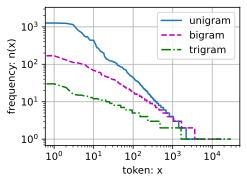

In [18]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

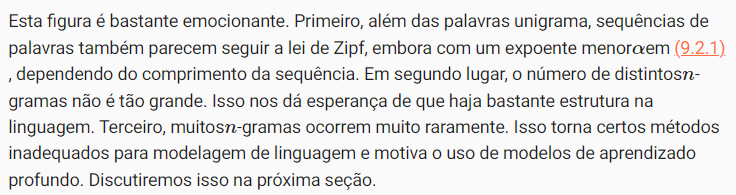

-------------------------

-------------------------

# Generalizando para fourgram

In [22]:
fourgram_tokens = ['--'.join(quadruple) for quadruple in zip(words[:-3], words[1:-2], words[2:-1], words[3:])]
fourgram_vocab = Vocab(fourgram_tokens)
fourgram_vocab.token_freqs[:10]

[('said--the--time--traveller', 12),
 ('said--the--medical--man', 11),
 ('it--seemed--to--me', 11),
 ('palace--of--green--porcelain', 8),
 ('the--time--machine--and', 7),
 ('as--i--did--so', 7),
 ('the--palace--of--green', 7),
 ('the--time--traveller--s', 6),
 ('of--the--time--machine', 6),
 ('the--time--machine--i', 6)]

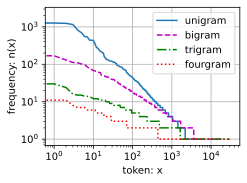

In [21]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
fourgram_freqs = [freq for token, freq in fourgram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs, fourgram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram', 'fourgram'])

# 9.2.6. Resumo

O texto está entre as formas mais comuns de dados de sequência encontrados no aprendizado profundo. Escolhas comuns para o que constitui um token são caracteres, palavras e pedaços de palavras. Para pré-processar o texto, geralmente:

- (i) dividimos o texto em tokens;
- (ii) construímos um vocabulário para mapear sequências de tokens para índices numéricos; e
- (iii) convertemos dados de texto em índices de tokens para modelos manipularem.

Na prática, a frequência de palavras tende a seguir a lei de Zipf. Isso é verdade não apenas para palavras individuais (unigramas), mas também para 
n-gramas.

# Código Agrupado

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


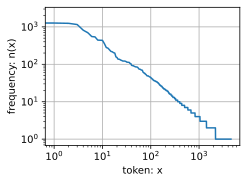

In [24]:
import collections
import random
import re
import torch
from d2l import torch as d2l

# ---------------------------------------------------------------------------------------------

# https://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt
# https://www.gutenberg.org/ebooks/35
class TimeMachine(d2l.DataModule): #@save
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

# # PARA LINK CODIFICADO EM 'UTF-8':
#     def _download(self):
#         fname = d2l.download('https://www.gutenberg.org/files/35/35-0.txt', self.root)
#         with open(fname, 'r', encoding='utf-8') as f:    # é preciso especificar a codificação UTF-8
#             return f.read()





data = TimeMachine()
raw_text = data._download()
raw_text[:80]                    # Livro

# ---------------------------------------------------------------------------------------------

@d2l.add_to_class(TimeMachine)  #@save
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:60]

# ---------------------------------------------------------------------------------------------

@d2l.add_to_class(TimeMachine)  #@save
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

# ---------------------------------------------------------------------------------------------

class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

# ---------------------------------------------------------------------------------------------

vocab = Vocab(tokens)              # objjeto vocab da classe Vocab
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

# ' '(espaço) tem índice 0, 'a' tem índice 1, 'b' tem índice 2, etc.

# ---------------------------------------------------------------------------------------------

@d2l.add_to_class(TimeMachine)  #@save
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

# ---------------------------------------------------------------------------------------------

words = text.split()    # separação de strings
vocab = Vocab(words)    # faz a indexação
vocab.token_freqs[:10]  # Count token frequencies: 10 most frequents

# ---------------------------------------------------------------------------------------------

freqs = [freq for token, freq in vocab.token_freqs]                # para unigrama
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

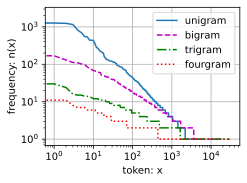

In [25]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

# ---------------------------------------------------------------------------------------------

trigram_tokens = ['--'.join(triple) for triple in zip(words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

# ---------------------------------------------------------------------------------------------

fourgram_tokens = ['--'.join(quadruple) for quadruple in zip(words[:-3], words[1:-2], words[2:-1], words[3:])]
fourgram_vocab = Vocab(fourgram_tokens)
fourgram_vocab.token_freqs[:10]

# ---------------------------------------------------------------------------------------------

bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
fourgram_freqs = [freq for token, freq in fourgram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs, fourgram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram', 'fourgram'])

# 9.2.7. Exercícios

# Ex. 1 - No experimento desta seção, tokenize o texto em palavras e varie o min_freq valor do argumento da Vocabinstância. Caracterize qualitativamente como as mudanças min_freq impactam o tamanho do vocabulário resultante.

In [57]:
import collections
import random
import re
import torch
from d2l import torch as d2l


class TimeMachine(d2l.DataModule): #@save
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

data = TimeMachine()
raw_text = data._download()
raw_text[:60]                       # livro



@d2l.add_to_class(TimeMachine)  #@save
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:60]


@d2l.add_to_class(TimeMachine)  #@save
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

# ------------------------------------------------------------------------------
@d2l.add_to_class(TimeMachine)  #@save
def _tokenize_word(self, text):
    return text.split()

tokens_word = data._tokenize_word(text)
','.join(tokens_word[:30])

'the,time,machine,by,h,g,wells,i,the,time,traveller,for,so,it,will,be,convenient,to,speak,of,him,was,expounding,a,recondite,matter,to,us,his,grey'

In [108]:
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [83]:
vocab = Vocab(tokens_word, min_freq=5)
indices = vocab[tokens_word[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [698, 724, 413, 91, 0, 0, 789, 337, 698, 724]
words: ['the', 'time', 'machine', 'by', '<unk>', '<unk>', 'wells', 'i', 'the', 'time']


In [68]:
vocab.to_tokens(4042)


'the'

In [70]:
vocab.to_tokens(2)

'a'

In [109]:
@d2l.add_to_class(TimeMachine)  #@save
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens_word)
    corpus = [vocab[token] for token in tokens_word]
    return corpus, vocab

corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(32776, 219)

------------------------------------

------------------------------------

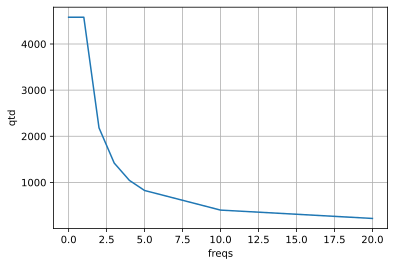

In [115]:
import collections
import random
import re
import torch
from d2l import torch as d2l

# ------------------------------------------------------------------------------

class TimeMachine(d2l.DataModule): #@save
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

data = TimeMachine()
raw_text = data._download()
raw_text[:60]                       # livro

# ------------------------------------------------------------------------------

@d2l.add_to_class(TimeMachine)  #@save
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()

text = data._preprocess(raw_text)
text[:60]


@d2l.add_to_class(TimeMachine)  #@save
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

# ------------------------------------------------------------------------------

class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

# ------------------------------------------------------------------------------

@d2l.add_to_class(TimeMachine)  #@save
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

# ------------------------------------------------------------------------------

words = text.split()                   # divide o texto em palavras
freqs = [0, 1, 2, 3, 4, 5, 10, 20]
qtd = []

for f in freqs:
    vocab = Vocab(tokens=words, min_freq=f)
    a = len(corpus)
    b = len(vocab)
    qtd.append(b)

d2l.plot(freqs, qtd, 'freqs', 'qtd', figsize=(6, 4))


# Ex. 3 - Encontre outras fontes de dados (baixe um conjunto de dados de aprendizado de máquina padrão, escolha outro livro de domínio público, faça scraping de um site, etc.). Para cada um, tokenize os dados nos níveis de palavra e caractere.

indices: [0, 21, 9, 6, 0, 17, 19, 16, 11, 6]
words: [' ', 't', 'h', 'e', ' ', 'p', 'r', 'o', 'j', 'e']


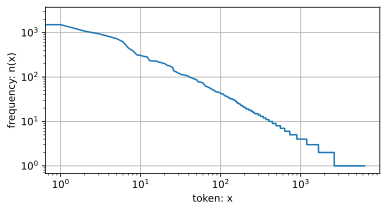

In [4]:
import collections
import random
import re
import torch
from d2l import torch as d2l

# ---------------------------------------------------------------------------------------------

# https://www.gutenberg.org/browse/languages/pt
# https://www.gutenberg.org/ebooks/67740
# https://www.gutenberg.org/cache/epub/67740/pg67740.txt

class TimeMachine(d2l.DataModule):  # @save
    """Iracema - José de Alencar."""

    def _download(self):
        fname = d2l.download('https://www.gutenberg.org/cache/epub/67740/pg67740.txt', self.root)
        with open(fname, 'r', encoding='utf-8') as f:    # é preciso especificar a codificação UTF-8
            return f.read()


data = TimeMachine()
raw_text = data._download()
raw_text[:80]  # Livro


# ---------------------------------------------------------------------------------------------

@d2l.add_to_class(TimeMachine)  # @save
def _preprocess(self, text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()


text = data._preprocess(raw_text)
text[:60]


# ---------------------------------------------------------------------------------------------

@d2l.add_to_class(TimeMachine)  # @save
def _tokenize(self, text):
    return list(text)


tokens = data._tokenize(text)
','.join(tokens[:30])


# ---------------------------------------------------------------------------------------------

class Vocab:  # @save
    """Vocabulary for text."""

    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]

        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)

        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']


# ---------------------------------------------------------------------------------------------

vocab = Vocab(tokens)  # objjeto vocab da classe Vocab
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))


# ' '(espaço) tem índice 0, 'a' tem índice 1, 'b' tem índice 2, etc.

# ---------------------------------------------------------------------------------------------

@d2l.add_to_class(TimeMachine)  # @save
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab


corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

# ---------------------------------------------------------------------------------------------

words = text.split()  # separação de strings
vocab = Vocab(words)  # faz a indexação
vocab.token_freqs[:10]  # Count token frequencies: 10 most frequents

# ---------------------------------------------------------------------------------------------

freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log', figsize=(6, 3))

# ---------------------------------------------------------------------------------------------


# Outras respostas:

https://pandalab.me/archives/converting_raw_text_into_sequence_data